# <font color='red'>Backtest vectorizado para una estrategia 'Regresion lineal' definida.</font>

### Hackeado by J3viton (learning BackTesting 2021).

---

En este notebook vamos a automatizar el backtesting para estrategias. Previamente tenemos que definir **la estrategia** usando el template (import estrategia_XX as rg), donde definimos la clase estrategia que contiene los metodos de analisis, entreda y salida de mercado. Este módulo se programa y adapta para cada estrategia. Luego en el metodo 'analisis' se crea un fichero excel con las metricas y rendimientos para evaluar la estrategia.

Vamos a usar el módulo Pandas, para realizar un backtest vectorizado, es decir calcular el resultado del backtest sin iterar sobre las filas (barras) de la serie temporal.

Posteriormente graficamos y mostramos los parametros generales que nos permiten analizar la estrategia.

#### J3Viton  2021

link a la base:

https://github.com/Python-para-Trading/Webinars-Docs/blob/master/Webinar%202/Webinar%202%20-%20Backtest%20con%20Pandas%20v%202.ipynb.

---

# DEFINICION DEL SISTEMA

Como es usual, importamos los módulos que vamos a necesitar para las distintas tareas, y preparamos Matplotlib para una mejor visualización de los gráficos en el notebook.

Se importa un modulo llamado analisis, en realidad se trata de un archivo .py con algunas funciones de apoyo para el trabajo, debe estar guardado en la misma carpeta que este notebook.
Se importa el módulo 'estrategia_XX', donde se define la estrategia de entreda y salida

Es importante tener clara la lógica del sistema, pues debemos plasmarla de forma sencilla y correcta en el dataframe para realizar el backtest del mismo.


In [1]:
import analisis
import regresionAMedia as rg  #cambiar segun el módulo con la estrategia implementado
import pandas as pd
import datetime as dt
from time import time
import yfinance as yf
import numpy as np

{'id': 1473252352, 'first_name': 'vital_bot', 'is_bot': True, 'username': 'vital_quant_bot', 'can_join_groups': True, 'can_read_all_group_messages': False, 'supports_inline_queries': False}


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

from IPython.display import display, Markdown

***0.- RECOGIDA DE DATOS INICIALES***
Introducimos el instrumento y las fechas


In [3]:
instrumento_ = 'hsy'   # ticker del valor en yahooFinance

Fecha_Cominezo_Backtesting = dt.datetime(2015,1,2)
Fecha_Final_Backtesting    = dt.datetime(2022,9,15)
Fecha_Final_Backtesting    = dt.datetime.today()




***1.- Rango fechas a analizar***

Definimos el rango global de datos historicos que vamos a evaluar.
Definimos la ventana que vamos a ir desplazando por todo el espectro para ir analilazando como se comporta la estrategia. La funion 'analisis' nos vale para tiempo real y para backtesting, para back le pasamos la ventana como si la fecha de fin de la ventana fuera la fecha de hoy.
Tener en cuenta que la 'ventana' tiene uqe tener una anchura que nos permita hacer los calculos en rolling (ejemplo EMA 200)

In [4]:
# Rango completo para backTesting
#start2 =dt.datetime(2008,1,2)
start2= Fecha_Cominezo_Backtesting 
#end2   =dt.datetime(2021,11,18)
end2= Fecha_Final_Backtesting 
start_G= start2.strftime("%Y-%m-%d")
end_G  =   end2.strftime("%Y-%m-%d")
TOTAL_len= (end2-start2).days
print('Tamaño timeseries global a analizar:  ', TOTAL_len, 'sesiones')

#ventana de analisis 200 sesiones
startWindow2 = start2  #dt.datetime(2008,1,5)
endWindow2   =startWindow2 + dt.timedelta(days=500) #ventana grande para que se puedan hacer los calculos de EMA200
startWindow= startWindow2.strftime("%Y-%m-%d")
endWindow  =   endWindow2.strftime("%Y-%m-%d")
window_len= (endWindow2-startWindow2).days
print('Tamaño de la ventana a analizar paso a paso:  ', window_len, 'sesiones')

Tamaño timeseries global a analizar:   2874 sesiones
Tamaño de la ventana a analizar paso a paso:   500 sesiones


In [5]:
 #dff = pd.DataFrame(columns=('Close','Volume', 'Senal', 'Dif_Close', 'Retornos','Capital'))

***2.- Descargamos los datos para el marco Global***

In [6]:
instrumento = instrumento_  # 'rovi.mc'  #Vamos título a título. Mejora: Conjunto de títulos

In [7]:
dff = yf.download(instrumento, start_G,end_G)

[*********************100%***********************]  1 of 1 completed


In [8]:
dff.dropna(inplace=True)  
dff.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,104.330002,104.589996,102.930000,103.709999,86.909256,786500
2015-01-05,103.150002,104.000000,102.500000,102.980003,86.297516,857800
2015-01-06,103.349998,104.300003,102.900002,103.320000,86.582413,1241200
2015-01-07,104.199997,105.489998,103.830002,105.139999,88.107597,1020600
2015-01-08,105.930000,107.500000,105.510002,107.169998,89.808739,1245800


***3.- Creamos la clase strategy que tiene toda la lógica***

In [9]:
regreMedia= rg.StrategyClass(back=True)    #Creamos la clase

***4.- Recorremos el dataframe con valores buscando las señales de la estrategia***

In [10]:
dff.index

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2022-11-01', '2022-11-02', '2022-11-03', '2022-11-04',
               '2022-11-07', '2022-11-08', '2022-11-09', '2022-11-10',
               '2022-11-11', '2022-11-14'],
              dtype='datetime64[ns]', name='Date', length=1982, freq=None)

## Proceso de backTesting ##

En este 'for' vamos recorriendo la muestra del historico de datos (TOTAL), desplazando una sesión hacia el futuro 
en cada iteracion. Vamos pasando la movilola del pasado sesión a sesión por el análisis descrito en Strategy class.

Ouput:
El sistema registra los siguientes parámetros:

.-
.-
.-


In [11]:
startWindow

'2015-01-02'

In [12]:
tiempo_inicial = time()   # Tomamos tiempos para ver cuanto tarda en hacer la estrategia

In [13]:
dfe = pd.DataFrame({'A' : []})   #df empty

***En este 'for' desplazamos la ventana sesión a sesión a lo largo de todo el rango de fechas. Dejamos que las funciones de la clase estrategia hagan el trabajo de comprar//vender y anotar***


In [14]:
#Para pruebas
#TOTAL_len =1000

for i in range(TOTAL_len):
    endWindow3   =endWindow2 + dt.timedelta(days=i) 
    endWindow    =endWindow3.strftime("%Y-%m-%d")
    print ('end date:', endWindow)
    
    if(endWindow in dff.index):
        df_aux= dff.loc[startWindow:endWindow]       #voy pasando los datos desplazando la ventana
        
        recogo = regreMedia.analisis(instrumento, startWindow, endWindow, df_aux) #Llamada a la clase estrategia. LA CLAVE DE TODO!!!
        
        print ('................................................Analizando, muestra', i, 'de', TOTAL_len, 'fecha', endWindow)
        
            
    else:
        print('..............Día sin sesión, next please')

        

end date: 2016-05-16
 Datos desde archivo
Coefficients: 
 [-0.04349182]
Independent term: 
 101.01244786113833
Coefficients: 
 [0.00146767]
Independent term: 
 90.09296669347962
Coefficients: 
 [-0.02847705]
Independent term: 
 94.3448137377307
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 0 de 2874 fecha 2016-05-16
end date: 2016-05-17
 Datos desde archivo
Coefficients: 
 [-0.04

 Datos desde archivo
Coefficients: 
 [-0.04126762]
Independent term: 
 100.75421521589107
Coefficients: 
 [0.00517428]
Independent term: 
 89.6829084333733
Coefficients: 
 [-0.02559851]
Independent term: 
 94.20101336818594
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 11 de 2874 fecha 2016-05-27
end date: 2016-05-28
..............Día sin sesión, next please
end date: 2016-05-29


 Datos desde archivo
Coefficients: 
 [-0.03809316]
Independent term: 
 100.3761298020522
Coefficients: 
 [0.01015156]
Independent term: 
 89.35156965227269
Coefficients: 
 [-0.02294141]
Independent term: 
 94.06018492211952
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 25 de 2874 fecha 2016-06-10
end date: 2016-06-11
..............Día sin sesión, next please
end date: 2016-06-12


 [-0.02006584]
Independent term: 
 93.89907943372586
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 38 de 2874 fecha 2016-06-23
end date: 2016-06-24
 Datos desde archivo
Coefficients: 
 [-0.03368514]
Independent term: 
 99.8375270529748
Coefficients: 
 [0.0182715]
Independent term: 
 88.90558608667175
Coefficients: 
 [-0.01972827]
Independent term: 
 93.87961282218433
  Instrument

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 52 de 2874 fecha 2016-07-07
end date: 2016-07-08
 Datos desde archivo
Coefficients: 
 [-0.02673968]
Independent term: 
 98.96561069380842
Coefficients: 
 [0.04011623]
Independent term: 
 87.38063537256042
Coefficients: 
 [-0.01613498]
Independent term: 
 93.66602297172192
  Instrumento  long_short_out                    date      prec

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 65 de 2874 fecha 2016-07-20
end date: 2016-07-21
 Datos desde archivo
Coefficients: 
 [-0.01962308]
Independent term: 
 98.05251003609638
Coefficients: 
 [0.06496708]
Independent term: 
 85.65537594353974
Coefficients: 
 [-0.01127463]
Independent term: 
 93.36284987864185
  Instrumento  long_short_out                    date      prec

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 78 de 2874 fecha 2016-08-02
end date: 2016-08-03
 Datos desde archivo
Coefficients: 
 [-0.01296408]
Independent term: 
 97.17803336726163
Coefficients: 
 [0.09358963]
Independent term: 
 83.47638191450888
Coefficients: 
 [-0.00506637]
Independent term: 
 92.89874623114287
  Instrumento  long_short_out                    date      prec

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 91 de 2874 fecha 2016-08-15
end date: 2016-08-16
 Datos desde archivo
Coefficients: 
 [-0.00684306]
Independent term: 
 96.35588565607803
Coefficients: 
 [0.11858267]
Independent term: 
 81.79117441775195
Coefficients: 
 [0.00470332]
Independent term: 
 91.99698863614233
  Instrumento  long_short_out                    date      preci

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
................................................Analizando, muestra 102 de 2874 fecha 2016-08-26
end date: 2016-08-27
..............Día sin sesión, next please
end date: 2016-08-28
..............Día sin sesión, next please
end date: 2016-08-29
 Datos desde archivo
Coefficients: 
 [-0.00114311]
Independent term: 
 95.57352941345592
Coefficients: 
 [0.13364979]
Independent term: 
 81.43054604943119
Coef

................................................Analizando, muestra 149 de 2874 fecha 2016-10-12
end date: 2016-10-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 150 de 2874 fecha 2016-10-13
end date: 2016-10-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 151 de 2874 fecha 2016-10-14
end date: 2016-10-15
..............Día sin sesión, next please
end date: 2016-10-16
..............Día sin sesión, next please
end date: 2016-10-17
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 154 de 2874 fecha 2016-10-17
end date: 2016-10-18
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 155 de 2874 fecha 2016-10-18
end date: 2016-10-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 156 de 2874 fecha 201

................................................Analizando, muestra 213 de 2874 fecha 2016-12-15
end date: 2016-12-16
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 214 de 2874 fecha 2016-12-16
end date: 2016-12-17
..............Día sin sesión, next please
end date: 2016-12-18
..............Día sin sesión, next please
end date: 2016-12-19
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 217 de 2874 fecha 2016-12-19
end date: 2016-12-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 218 de 2874 fecha 2016-12-20
end date: 2016-12-21
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 219 de 2874 fecha 2016-12-21
end date: 2016-12-22
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 220 de 2874 fecha 201

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 275 de 2874 fecha 2017-02-15
end date: 2017-02-16
 Datos desde archivo
Coefficients: 
 [0.01015218]
Independent term: 
 93.71535508260708
Coefficients: 
 [0.02849456]
Independent term: 
 98.41664174094129
Coefficients

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 288 de 2874 fecha 2017-02-28
end date: 2017-03-01
 Datos desde archivo
Coefficients: 
 [0.01161577]
Independent term: 
 93.4526239078108
Coefficients: 
 [0.0256115]
Independent term: 
 99.34180567954904
Coefficients: 

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 298 de 2874 fecha 2017-03-10
end date: 2017-03-11
..............Día sin sesión, next please
end date: 2017-03-12
..............Día sin sesión, next please
end date: 2017-03-13
 Datos desde archivo
Coefficients: 
 [0.0

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 310 de 2874 fecha 2017-03-22
end date: 2017-03-23
 Datos desde archivo
Coefficients: 
 [0.01424756]
Independent term: 
 92.96998495971819
Coefficients: 
 [0.01482135]
Independent term: 
 101.75557603750656
Coefficient

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 322 de 2874 fecha 2017-04-03
end date: 2017-04-04
 Datos desde archivo
Coefficients: 
 [0.01539318]
Independent term: 
 92.75518938186053
Coefficients: 
 [0.01231569]
Independent term: 
 102.51373864928289
Coefficient

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 332 de 2874 fecha 2017-04-13
end date: 2017-04-14
..............Día sin sesión, next please
end date: 2017-04-15
..............Día sin sesión, next please
end date: 2017-04-16
..............Día sin sesión, next please

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 345 de 2874 fecha 2017-04-26
end date: 2017-04-27
 Datos desde archivo
Coefficients: 
 [0.01728016]
Independent term: 
 92.39418601426988
Coefficients: 
 [0.02255572]
Independent term: 
 101.8659059917393
Coefficients

 Datos desde archivo
Coefficients: 
 [0.01784214]
Independent term: 
 92.28443737220181
Coefficients: 
 [0.03129267]
Independent term: 
 100.92847918154588
Coefficients: 
 [0.03420061]
Independent term: 
 96.0586308449028
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, mue

Coefficients: 
 [0.01847222]
Independent term: 
 92.15967716032355
Coefficients: 
 [0.04350592]
Independent term: 
 99.60036126891178
Coefficients: 
 [0.03446221]
Independent term: 
 96.37930540098259
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 367 de 2874 fech

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 380 de 2874 fecha 2017-05-31
end date: 2017-06-01
 Datos desde archivo
Coefficients: 
 [0.0200799]
Independent term: 
 91.83695138387802
Coefficients: 
 [0.06738451]
Independent term: 
 97.37059106399764
Coefficients:

Coefficients: 
 [0.03925684]
Independent term: 
 96.53039188744614
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2016-08-30 00:00:00.000   99.650002   8.511799   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.451854           NaN       NaN  
................................................Analizando, muestra 392 de 2874 fecha 2017-06-12
end date: 2017-06-13
 Datos desde archivo
Coefficients: 
 [0.02140549]
Independent term: 
 91.56729358223528
Coefficients

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               1 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 402 de 2874 fecha 2017-06-22
end date: 2017-06-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 403 de 2874 fecha 2017-06-23
end date: 2017-06-24
..........

 [0.08633127]
Independent term: 
 96.53643879790803
Coefficients: 
 [0.04912704]
Independent term: 
 96.31215337655613
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 421 de 2874 fecha 2017-07-11
end date: 2017-07-12
 Datos desde archivo
Coefficients: 
 [0.02249504

Coefficients: 
 [0.02251241]
Independent term: 
 91.33875729843935
Coefficients: 
 [0.0746982]
Independent term: 
 98.11567918919805
Coefficients: 
 [0.05147299]
Independent term: 
 96.39849507289964
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 431 de 2874 fecha

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 443 de 2874 fecha 2017-08-02
end date: 2017-08-03
 Datos desde archivo
Coefficients: 
 [0.02251502]
Independent term: 
 91.33823332508223
Coefficients: 
 [0.06090849]
Independent term: 
 99.95940480246473
Coefficients

 Datos desde archivo
Coefficients: 
 [0.02244266]
Independent term: 
 91.35399646430135
Coefficients: 
 [0.04896079]
Independent term: 
 101.48635108833882
Coefficients: 
 [0.05288631]
Independent term: 
 96.92056055652634
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

Coefficients: 
 [0.02251842]
Independent term: 
 91.33728703440612
Coefficients: 
 [0.04268308]
Independent term: 
 102.35588403274764
Coefficients: 
 [0.05229279]
Independent term: 
 97.31183113250312
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 465 de 2874 fec

  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 478 de 2874 fecha 2017-09-06
end date: 2017-09-07
 Datos desde archivo
Coefficients: 
 [0.02237932]
Independent term: 
 91.36829595407507
Coefficients: 
 [0.03028373]
Independent term: 
 103.86966903117165
Coefficient

 Datos desde archivo
Coefficients: 
 [0.02263952]
Independent term: 
 91.30946917927166
Coefficients: 
 [0.0228111]
Independent term: 
 105.02999585963008
Coefficients: 
 [0.04917827]
Independent term: 
 98.27262349427757
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.02272779]
Independent term: 
 91.28933291966834
Coefficients: 
 [0.01240564]
Independent term: 
 106.43133897923711
Coefficients: 
 [0.04667269]
Independent term: 
 98.85731568084294
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.02287108]
Independent term: 
 91.25621865636411
Coefficients: 
 [0.00607186]
Independent term: 
 107.33140026946566
Coefficients: 
 [0.04373287]
Independent term: 
 99.48298424377968
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.02312199]
Independent term: 
 91.19756812565541
Coefficients: 
 [0.0031012]
Independent term: 
 107.87828085144955
Coefficients: 
 [0.04071475]
Independent term: 
 100.10981452639841
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

Coefficients: 
 [0.02301291]
Independent term: 
 91.22345382443639
Coefficients: 
 [-0.00313914]
Independent term: 
 108.56489421218188
Coefficients: 
 [0.03757077]
Independent term: 
 100.73640031485513
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 534 de 2874 f

 Datos desde archivo
Coefficients: 
 [0.02293507]
Independent term: 
 91.24200294736401
Coefficients: 
 [-0.00792967]
Independent term: 
 109.09155249979959
Coefficients: 
 [0.03420596]
Independent term: 
 101.36295441744099
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.02301281]
Independent term: 
 91.22323640385056
Coefficients: 
 [-0.0095305]
Independent term: 
 109.33788513525208
Coefficients: 
 [0.03088562]
Independent term: 
 101.970180203134
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.02328515]
Independent term: 
 91.15654760766071
Coefficients: 
 [-0.00663101]
Independent term: 
 109.17783577193076
Coefficients: 
 [0.02786506]
Independent term: 
 102.53218690422244
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

Coefficients: 
 [-0.00069336]
Independent term: 
 108.77898935004846
Coefficients: 
 [0.02546495]
Independent term: 
 103.02626360208853
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 581 de 2874 fecha 2017-12-18
end date: 2017-12-19
 Datos desde archivo
Coefficie

 Datos desde archivo
Coefficients: 
 [0.02420048]
Independent term: 
 90.92904284062301
Coefficients: 
 [0.00637845]
Independent term: 
 108.30794460239694
Coefficients: 
 [0.02377166]
Independent term: 
 103.44775236992777
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.02444094]
Independent term: 
 90.86835470964773
Coefficients: 
 [0.00951726]
Independent term: 
 108.14803258867407
Coefficients: 
 [0.02258548]
Independent term: 
 103.81333173862967
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.02442037]
Independent term: 
 90.87356473519566
Coefficients: 
 [0.00978639]
Independent term: 
 108.1322043962621
Coefficients: 
 [0.02157617]
Independent term: 
 104.14690498032941
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.02422725]
Independent term: 
 90.92358239596625
Coefficients: 
 [0.0071393]
Independent term: 
 108.3413894482513
Coefficients: 
 [0.02064596]
Independent term: 
 104.45668632321505
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mue

Coefficients: 
 [0.02343837]
Independent term: 
 91.12907548460954
Coefficients: 
 [-0.00544715]
Independent term: 
 109.27019098424199
Coefficients: 
 [0.01905739]
Independent term: 
 104.79563574684985
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 640 de 2874 f

 Datos desde archivo
Coefficients: 
 [0.02258955]
Independent term: 
 91.35249023900458
Coefficients: 
 [-0.01967122]
Independent term: 
 110.34418641617049
Coefficients: 
 [0.01656708]
Independent term: 
 105.18554280335213
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

Coefficients: 
 [-0.02681731]
Independent term: 
 110.6029222573807
Coefficients: 
 [0.01337586]
Independent term: 
 105.60404965261927
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 665 de 2874 fecha 2018-03-12
end date: 2018-03-13
 Datos desde archivo
Coefficien

 Datos desde archivo
Coefficients: 
 [0.0212129]
Independent term: 
 91.72020614040673
Coefficients: 
 [-0.02625516]
Independent term: 
 109.93043879380868
Coefficients: 
 [0.01033842]
Independent term: 
 105.95740998745269
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.02043855]
Independent term: 
 91.93013279662458
Coefficients: 
 [-0.02850415]
Independent term: 
 109.51576290643037
Coefficients: 
 [0.00740923]
Independent term: 
 106.2453129855345
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01964591]
Independent term: 
 92.14724372243529
Coefficients: 
 [-0.0348093]
Independent term: 
 109.62727505242647
Coefficients: 
 [0.00443536]
Independent term: 
 106.49513776937832
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01864965]
Independent term: 
 92.42274897972416
Coefficients: 
 [-0.04914437]
Independent term: 
 110.56636458553484
Coefficients: 
 [0.00083079]
Independent term: 
 106.77311464559017
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.01753717]
Independent term: 
 92.73331619950861
Coefficients: 
 [-0.06547564]
Independent term: 
 111.61847650214807
Coefficients: 
 [-0.0037433]
Independent term: 
 107.11317092279691
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

Coefficients: 
 [0.01655431]
Independent term: 
 93.0103158571836
Coefficients: 
 [-0.07877686]
Independent term: 
 112.4072974839851
Coefficients: 
 [-0.00906864]
Independent term: 
 107.49369764248314
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 732 de 2874 fe

 Datos desde archivo
Coefficients: 
 [0.01555116]
Independent term: 
 93.29572424413155
Coefficients: 
 [-0.09275958]
Independent term: 
 113.24807810313666
Coefficients: 
 [-0.01503943]
Independent term: 
 107.908679077553
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01458142]
Independent term: 
 93.57414536976977
Coefficients: 
 [-0.10366523]
Independent term: 
 113.71094078519451
Coefficients: 
 [-0.02152866]
Independent term: 
 108.34238603616348
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando,

 Datos desde archivo
Coefficients: 
 [0.013705]
Independent term: 
 93.82814723286191
Coefficients: 
 [-0.11469651]
Independent term: 
 114.29765243416402
Coefficients: 
 [-0.02833922]
Independent term: 
 108.78213369479187
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

Coefficients: 
 [0.0129624]
Independent term: 
 94.0453585230031
Coefficients: 
 [-0.11733539]
Independent term: 
 113.93722096001925
Coefficients: 
 [-0.03511703]
Independent term: 
 109.19340558882381
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 780 de 2874 fe

 Datos desde archivo
Coefficients: 
 [0.01226557]
Independent term: 
 94.251058534804
Coefficients: 
 [-0.12012325]
Independent term: 
 113.66131328525829
Coefficients: 
 [-0.0415455]
Independent term: 
 109.54475412393185
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

Coefficients: 
 [0.01157723]
Independent term: 
 94.4559633420068
Coefficients: 
 [-0.1209609]
Independent term: 
 113.1433595868011
Coefficients: 
 [-0.04768903]
Independent term: 
 109.8431386007452
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, muestra 802 de 2874 fech

 Datos desde archivo
Coefficients: 
 [0.01118944]
Independent term: 
 94.5724730095071
Coefficients: 
 [-0.11324127]
Independent term: 
 111.90445654114681
Coefficients: 
 [-0.0529964]
Independent term: 
 110.04334624503687
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01089503]
Independent term: 
 94.66165113368764
Coefficients: 
 [-0.10712311]
Independent term: 
 111.02019954624461
Coefficients: 
 [-0.0573797]
Independent term: 
 110.1471068422835
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01061761]
Independent term: 
 94.74650705984328
Coefficients: 
 [-0.09976332]
Independent term: 
 110.00025060852963
Coefficients: 
 [-0.06090411]
Independent term: 
 110.1729563191118
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.01055468]
Independent term: 
 94.76585621082307
Coefficients: 
 [-0.08497404]
Independent term: 
 108.31461642706572
Coefficients: 
 [-0.06327668]
Independent term: 
 110.087383034244
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01052026]
Independent term: 
 94.77661446030324
Coefficients: 
 [-0.06607003]
Independent term: 
 106.14361775981845
Coefficients: 
 [-0.0641342]
Independent term: 
 109.86017446648955
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.01038539]
Independent term: 
 94.81893305518264
Coefficients: 
 [-0.0457343]
Independent term: 
 103.66681319507201
Coefficients: 
 [-0.06341254]
Independent term: 
 109.46809707608881
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.01037047]
Independent term: 
 94.82366315417202
Coefficients: 
 [-0.02019743]
Independent term: 
 100.71454449098502
Coefficients: 
 [-0.0609271]
Independent term: 
 108.89171192789205
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.01040407]
Independent term: 
 94.8129617577766
Coefficients: 
 [0.00442026]
Independent term: 
 97.99253427306218
Coefficients: 
 [-0.05669774]
Independent term: 
 108.14203735148884
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.01051857]
Independent term: 
 94.7761025811025
Coefficients: 
 [0.02805012]
Independent term: 
 95.55311341926233
Coefficients: 
 [-0.05099147]
Independent term: 
 107.25795322922963
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.01068695]
Independent term: 
 94.72145772264672
Coefficients: 
 [0.05099086]
Independent term: 
 93.31340896720317
Coefficients: 
 [-0.04382027]
Independent term: 
 106.2475787286779
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.01076093]
Independent term: 
 94.69723388943328
Coefficients: 
 [0.06213007]
Independent term: 
 92.49045815311261
Coefficients: 
 [-0.03605606]
Independent term: 
 105.21794492570014
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.01090252]
Independent term: 
 94.65052149348205
Coefficients: 
 [0.07287181]
Independent term: 
 91.81875514357837
Coefficients: 
 [-0.02802154]
Independent term: 
 104.20757966973315
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.0109129]
Independent term: 
 94.64709186646006
Coefficients: 
 [0.08113566]
Independent term: 
 91.24495198150179
Coefficients: 
 [-0.01990638]
Independent term: 
 103.2315564575889
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.01093735]
Independent term: 
 94.63890516392436
Coefficients: 
 [0.0901126]
Independent term: 
 90.59119651111203
Coefficients: 
 [-0.01170086]
Independent term: 
 102.27583304917044
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.01099241]
Independent term: 
 94.62028199431322
Coefficients: 
 [0.09674409]
Independent term: 
 90.28601311754825
Coefficients: 
 [-0.00361577]
Independent term: 
 101.367511546711
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2017-06-22 00:00:00.000  110.519997   3.761761   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   2.986511           NaN       NaN  
................................................Analizando, mue

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1009 de 2874 fecha 2019-02-19
end date: 2019-02-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1010 de 2874 fecha 2019-02-20
end date: 2019-02-21
 Datos desde archivo
Coefficients: 
 [0.01116949]
Independent term: 
 94.55921279813624
Coefficients: 
 [0.09949909]
Independent term: 
 91.44004035608093
Coefficients: 
 [0.01685641]
Independent term: 
 99.2409667104337
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.3000

 Datos desde archivo
Coefficients: 
 [0.01135632]
Independent term: 
 94.49420810089049
Coefficients: 
 [0.0991639]
Independent term: 
 92.1919416740759
Coefficients: 
 [0.0231771]
Independent term: 
 98.67571622508461
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, muestr

 Datos desde archivo
Coefficients: 
 [0.0115533]
Independent term: 
 94.42518307254717
Coefficients: 
 [0.09685521]
Independent term: 
 93.18845690485256
Coefficients: 
 [0.02894516]
Independent term: 
 98.21841030353806
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.01175629]
Independent term: 
 94.35345386451735
Coefficients: 
 [0.09194743]
Independent term: 
 94.5026807733792
Coefficients: 
 [0.03392526]
Independent term: 
 97.89086604487422
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.0120892]
Independent term: 
 94.2349817067388
Coefficients: 
 [0.09084064]
Independent term: 
 95.51870605354878
Coefficients: 
 [0.03834142]
Independent term: 
 97.67373297122697
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, muest

 Datos desde archivo
Coefficients: 
 [0.0124646]
Independent term: 
 94.10039426176837
Coefficients: 
 [0.09047556]
Independent term: 
 96.48213148657956
Coefficients: 
 [0.04236417]
Independent term: 
 97.54976115152846
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.01301609]
Independent term: 
 93.90113075066031
Coefficients: 
 [0.0946223]
Independent term: 
 97.1583314946872
Coefficients: 
 [0.04618848]
Independent term: 
 97.50024452435183
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, muest

 Datos desde archivo
Coefficients: 
 [0.01366802]
Independent term: 
 93.66389052176247
Coefficients: 
 [0.09751168]
Independent term: 
 98.1649881687449
Coefficients: 
 [0.0500189]
Independent term: 
 97.51826467074991
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, muest

 Datos desde archivo
Coefficients: 
 [0.01446737]
Independent term: 
 93.37089947636069
Coefficients: 
 [0.11008465]
Independent term: 
 98.15147757459042
Coefficients: 
 [0.05419778]
Independent term: 
 97.56881953462664
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.01531569]
Independent term: 
 93.05767329517357
Coefficients: 
 [0.12277034]
Independent term: 
 98.20270132491838
Coefficients: 
 [0.05899174]
Independent term: 
 97.62053992533993
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.01635589]
Independent term: 
 92.67089559708123
Coefficients: 
 [0.14141641]
Independent term: 
 97.84071759238172
Coefficients: 
 [0.06475589]
Independent term: 
 97.64384067044884
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.01731897]
Independent term: 
 92.3102691142789
Coefficients: 
 [0.15777696]
Independent term: 
 97.60229235407131
Coefficients: 
 [0.07137145]
Independent term: 
 97.65055708528386
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.01824561]
Independent term: 
 91.9607311452164
Coefficients: 
 [0.17424872]
Independent term: 
 97.26465230913304
Coefficients: 
 [0.07873566]
Independent term: 
 97.62976381997065
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.0193203]
Independent term: 
 91.55243168114859
Coefficients: 
 [0.19094467]
Independent term: 
 97.20365551507294
Coefficients: 
 [0.08674056]
Independent term: 
 97.60220123248855
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.02064144]
Independent term: 
 91.04705938609226
Coefficients: 
 [0.21499255]
Independent term: 
 96.68609136097467
Coefficients: 
 [0.09578638]
Independent term: 
 97.54927384315279
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.02199514]
Independent term: 
 90.52562078616634
Coefficients: 
 [0.24046855]
Independent term: 
 96.03642867814249
Coefficients: 
 [0.1060147]
Independent term: 
 97.45872609083924
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.0234023]
Independent term: 
 89.97984847110436
Coefficients: 
 [0.26490293]
Independent term: 
 95.63055868234207
Coefficients: 
 [0.11737757]
Independent term: 
 97.33578970847172
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.02485485]
Independent term: 
 89.4126300213607
Coefficients: 
 [0.29105336]
Independent term: 
 95.0858407114513
Coefficients: 
 [0.12987443]
Independent term: 
 97.17965463531597
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-01-25 00:00:00.000  104.300003   5.805268   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   3.815444           NaN       NaN  
................................................Analizando, muest

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1221 de 2874 fecha 2019-09-19
end date: 2019-09-20
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1222 de 2874 fecha 2019-09-20
end date: 2019-09-21
..............Día sin sesión, next please
end date: 2019-09-22
..............Día sin sesión, next please
end date: 2019-09-23
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1225 de 2874 fecha 2019-09-23
end date: 2019-09-24
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1226 de 2874 fecha 2019-09-24
end date: 2019-09-25
 Datos desde archivo
Coefficients: 
 [0.0268552]
Independent term: 
 88.62423886558426
Coefficients: 
 [0.31020007]
Independent term: 
 96.37319300865059
Coefficients: 
 [0.15244086]
Independent term: 
 96.98511304922704
  Instrumento  long_s

 Datos desde archivo
Coefficients: 
 [0.02785132]
Independent term: 
 88.22810646768471
Coefficients: 
 [0.31668587]
Independent term: 
 97.39285561746627
Coefficients: 
 [0.16338327]
Independent term: 
 96.97987565305944
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-09-13 00:00:00.000  148.570007   7.071851   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.077132           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.02894924]
Independent term: 
 87.7888098010095
Coefficients: 
 [0.31837707]
Independent term: 
 99.19073158605774
Coefficients: 
 [0.17532028]
Independent term: 
 97.08430333490728
***************** NoGo
***************** Señal...
!
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               1 2019-10-16 00:00:00.000  151.529999  11.336146   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.002031           NaN       NaN  
............

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1297 de 2874 fecha 2019-12-04
end date: 2019-12-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1298 de 2874 fecha 2019-12-05
end date: 2019-12-06
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1299 de 2874 fecha 2019-12-06
end date: 2019-12-07
..............Día sin sesión, next please
end date: 2019-12-08
..............Día sin sesión, next please
end date: 2019-12-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1302 de 2874 fecha 2019-12-09
end date: 2019-12-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1303 de 2874 fecha 2019-12-10
end date: 2019-12-11
aqui estoy en out
 datos desde archivo
.............................................

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1362 de 2874 fecha 2020-02-07
end date: 2020-02-08
..............Día sin sesión, next please
end date: 2020-02-09
..............Día sin sesión, next please
end date: 2020-02-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1365 de 2874 fecha 2020-02-10
end date: 2020-02-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1366 de 2874 fecha 2020-02-11
end date: 2020-02-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1367 de 2874 fecha 2020-02-12
end date: 2020-02-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1368 de 2874 fecha 2020-02-13
end date: 2020-02-14
aqui estoy en out
 datos desde archivo
.............................................

 Datos desde archivo
Coefficients: 
 [0.03726935]
Independent term: 
 84.31231947069908
Coefficients: 
 [0.03187267]
Independent term: 
 145.6038689513705
Coefficients: 
 [0.16307823]
Independent term: 
 116.59876295387494
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.03707861]
Independent term: 
 84.39574160218947
Coefficients: 
 [-0.00800557]
Independent term: 
 149.13075366575325
Coefficients: 
 [0.1510341]
Independent term: 
 118.99822596637355
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.03725357]
Independent term: 
 84.31854319145138
Coefficients: 
 [-0.03149872]
Independent term: 
 151.57822254693332
Coefficients: 
 [0.13771377]
Independent term: 
 121.42470926908217
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03750618]
Independent term: 
 84.20655875775157
Coefficients: 
 [-0.05223151]
Independent term: 
 153.9126853783451
Coefficients: 
 [0.12380999]
Independent term: 
 123.84717049372658
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.03747803]
Independent term: 
 84.21914910395645
Coefficients: 
 [-0.07934297]
Independent term: 
 156.29562596107598
Coefficients: 
 [0.10903479]
Independent term: 
 126.27276961166064
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03740094]
Independent term: 
 84.25375983877687
Coefficients: 
 [-0.09657154]
Independent term: 
 157.28051881704758
Coefficients: 
 [0.09373989]
Independent term: 
 128.6320193571669
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.03730549]
Independent term: 
 84.29683689112979
Coefficients: 
 [-0.10920431]
Independent term: 
 157.67822933140087
Coefficients: 
 [0.0784732]
Independent term: 
 130.86102284472938
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.0373057]
Independent term: 
 84.29675798238236
Coefficients: 
 [-0.11088155]
Independent term: 
 157.0015638710136
Coefficients: 
 [0.06393482]
Independent term: 
 132.89879158261436
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.03720109]
Independent term: 
 84.34455326808202
Coefficients: 
 [-0.11126262]
Independent term: 
 155.92328049389286
Coefficients: 
 [0.05044761]
Independent term: 
 134.7087070690806
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.03703087]
Independent term: 
 84.42277498588133
Coefficients: 
 [-0.11897587]
Independent term: 
 155.70909904593853
Coefficients: 
 [0.03777942]
Independent term: 
 136.316787753904
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.03686103]
Independent term: 
 84.50127241080331
Coefficients: 
 [-0.1239384]
Independent term: 
 155.21042144206032
Coefficients: 
 [0.0254817]
Independent term: 
 137.78922681074212
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.03691803]
Independent term: 
 84.4746934422691
Coefficients: 
 [-0.1133787]
Independent term: 
 153.46953072505212
Coefficients: 
 [0.01429847]
Independent term: 
 139.0651830372722
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.03712778]
Independent term: 
 84.37666050700483
Coefficients: 
 [-0.09517151]
Independent term: 
 151.29146509312872
Coefficients: 
 [0.00534054]
Independent term: 
 140.07077919581974
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.0373265]
Independent term: 
 84.28320191996852
Coefficients: 
 [-0.08516843]
Independent term: 
 150.2337592338448
Coefficients: 
 [-0.00190945]
Independent term: 
 140.8792134663548
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.03759053]
Independent term: 
 84.15836151815604
Coefficients: 
 [-0.07714634]
Independent term: 
 149.69696088079198
Coefficients: 
 [-0.00792831]
Independent term: 
 141.57066456491512
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando,

 Datos desde archivo
Coefficients: 
 [0.03783351]
Independent term: 
 84.0428420393353
Coefficients: 
 [-0.06464038]
Independent term: 
 148.52996830612867
Coefficients: 
 [-0.01271701]
Independent term: 
 142.14753718378324
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03792617]
Independent term: 
 83.99858615091215
Coefficients: 
 [-0.05655342]
Independent term: 
 147.48506522449094
Coefficients: 
 [-0.01630928]
Independent term: 
 142.59124858903917
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando,

 Datos desde archivo
Coefficients: 
 [0.03794873]
Independent term: 
 83.98768982694673
Coefficients: 
 [-0.05050536]
Independent term: 
 146.5289833399075
Coefficients: 
 [-0.01918829]
Independent term: 
 142.92718544259773
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03807601]
Independent term: 
 83.92611893042601
Coefficients: 
 [-0.04069103]
Independent term: 
 145.48635788988713
Coefficients: 
 [-0.0212365]
Independent term: 
 143.16409922943592
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03825843]
Independent term: 
 83.83746288521318
Coefficients: 
 [-0.02829195]
Independent term: 
 144.33514852609207
Coefficients: 
 [-0.02214209]
Independent term: 
 143.2888766724483
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03827985]
Independent term: 
 83.82698928533978
Coefficients: 
 [-0.01835652]
Independent term: 
 142.98347351415833
Coefficients: 
 [-0.02222931]
Independent term: 
 143.3161409030108
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03852483]
Independent term: 
 83.70653334127056
Coefficients: 
 [0.00980133]
Independent term: 
 140.08006782076254
Coefficients: 
 [-0.02079565]
Independent term: 
 143.1710374249982
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.03870027]
Independent term: 
 83.61986699286088
Coefficients: 
 [0.03743075]
Independent term: 
 137.05319008556765
Coefficients: 
 [-0.01726272]
Independent term: 
 142.80699679122435
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03888602]
Independent term: 
 83.52756293140658
Coefficients: 
 [0.07151878]
Independent term: 
 133.28348067667946
Coefficients: 
 [-0.01157429]
Independent term: 
 142.19888425895283
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, 

 Datos desde archivo
Coefficients: 
 [0.03905995]
Independent term: 
 83.44068231322433
Coefficients: 
 [0.09912892]
Independent term: 
 130.3941221880557
Coefficients: 
 [-0.00405017]
Independent term: 
 141.39578383627506
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.03923343]
Independent term: 
 83.3535566617402
Coefficients: 
 [0.1046665]
Independent term: 
 130.47343250559337
Coefficients: 
 [0.00439013]
Independent term: 
 140.5170027827677
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.03938713]
Independent term: 
 83.27598136061141
Coefficients: 
 [0.0970808]
Independent term: 
 132.18435948955477
Coefficients: 
 [0.01161694]
Independent term: 
 139.84198115092963
Operacion poco eficiente
***************** NoGo
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2019-10-25 00:00:00.000  143.309998  20.293140   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   6.034772           NaN       NaN  
..............

 Datos desde archivo
Coefficients: 
 [0.03949191]
Independent term: 
 83.22281670130256
Coefficients: 
 [0.10213865]
Independent term: 
 132.02040386712372
Coefficients: 
 [0.01833782]
Independent term: 
 139.2566009228663
***************** NoGo
***************** Señal...
!
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               1 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
..........

 Datos desde archivo
Coefficients: 
 [0.03972467]
Independent term: 
 83.10354740747489
Coefficients: 
 [0.1039289]
Independent term: 
 132.99422404616627
Coefficients: 
 [0.03446676]
Independent term: 
 137.93401171977771
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.03977778]
Independent term: 
 83.07606599062724
Coefficients: 
 [0.09335881]
Independent term: 
 134.70194778100768
Coefficients: 
 [0.03931745]
Independent term: 
 137.62885556566854
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.0399444]
Independent term: 
 82.98949065965988
Coefficients: 
 [0.09183137]
Independent term: 
 135.64422869440335
Coefficients: 
 [0.04332858]
Independent term: 
 137.4536599246885
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.0401865]
Independent term: 
 82.86306263583711
Coefficients: 
 [0.09219884]
Independent term: 
 136.62511517766697
Coefficients: 
 [0.04711555]
Independent term: 
 137.35070484933175
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04044488]
Independent term: 
 82.72745944959489
Coefficients: 
 [0.08918849]
Independent term: 
 138.09044501005715
Coefficients: 
 [0.05050893]
Independent term: 
 137.3519300795568
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.0407188]
Independent term: 
 82.58295961500917
Coefficients: 
 [0.08294431]
Independent term: 
 140.00964067943062
Coefficients: 
 [0.05318466]
Independent term: 
 137.49490934027077
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04101906]
Independent term: 
 82.42372249687128
Coefficients: 
 [0.07954111]
Independent term: 
 141.62120941389853
Coefficients: 
 [0.0551605]
Independent term: 
 137.77487804263816
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04142492]
Independent term: 
 82.20745558411423
Coefficients: 
 [0.09587764]
Independent term: 
 141.03697530717992
Coefficients: 
 [0.05766898]
Independent term: 
 138.05421759992504
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.04188009]
Independent term: 
 81.96370472947287
Coefficients: 
 [0.11401679]
Independent term: 
 140.4198798860009
Coefficients: 
 [0.06142204]
Independent term: 
 138.2533048179951
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.04231721]
Independent term: 
 81.72846618832358
Coefficients: 
 [0.133805]
Independent term: 
 139.49895300110774
Coefficients: 
 [0.0663282]
Independent term: 
 138.38032507420078
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.04273202]
Independent term: 
 81.50414430496758
Coefficients: 
 [0.15264045]
Independent term: 
 138.60767572431422
Coefficients: 
 [0.07238412]
Independent term: 
 138.4240181992616
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04312199]
Independent term: 
 81.29218984740966
Coefficients: 
 [0.16547241]
Independent term: 
 138.4042954311086
Coefficients: 
 [0.07915028]
Independent term: 
 138.42393115583968
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04354752]
Independent term: 
 81.05977048799355
Coefficients: 
 [0.16961411]
Independent term: 
 139.4920461466775
Coefficients: 
 [0.08600707]
Independent term: 
 138.46416351890036
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04400463]
Independent term: 
 80.80890597863706
Coefficients: 
 [0.1783357]
Independent term: 
 140.07849843722673
Coefficients: 
 [0.09283916]
Independent term: 
 138.5677356658104
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.04443594]
Independent term: 
 80.5710409538516
Coefficients: 
 [0.18980848]
Independent term: 
 140.16160710576756
Coefficients: 
 [0.099886]
Independent term: 
 138.69150643649562
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.04486329]
Independent term: 
 80.33420755738587
Coefficients: 
 [0.19377695]
Independent term: 
 141.2069937042692
Coefficients: 
 [0.10704668]
Independent term: 
 138.83937047978299
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-01-27 00:00:00.000  146.190002   6.258131   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.402367           NaN       NaN  
................................................Analizando, mu

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1941 de 2874 fecha 2021-09-08
end date: 2021-09-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1942 de 2874 fecha 2021-09-09
end date: 2021-09-10
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1943 de 2874 fecha 2021-09-10
end date: 2021-09-11
..............Día sin sesión, next please
end date: 2021-09-12
..............Día sin sesión, next please
end date: 2021-09-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1946 de 2874 fecha 2021-09-13
end date: 2021-09-14
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1947 de 2874 fecha 2021-09-14
end date: 2021-09-15
aqui estoy en out
 datos desde archivo
.............................................

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1997 de 2874 fecha 2021-11-03
end date: 2021-11-04
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1998 de 2874 fecha 2021-11-04
end date: 2021-11-05
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 1999 de 2874 fecha 2021-11-05
end date: 2021-11-06
..............Día sin sesión, next please
end date: 2021-11-07
..............Día sin sesión, next please
end date: 2021-11-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2002 de 2874 fecha 2021-11-08
end date: 2021-11-09
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2003 de 2874 fecha 2021-11-09
end date: 2021-11-10
aqui estoy en out
 datos desde archivo
.............................................

 Datos desde archivo
Coefficients: 
 [0.04816327]
Independent term: 
 78.4549948387974
Coefficients: 
 [0.12053195]
Independent term: 
 160.78747099919107
Coefficients: 
 [0.14221092]
Independent term: 
 145.49232677442404
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04856453]
Independent term: 
 78.22017932359196
Coefficients: 
 [0.11348573]
Independent term: 
 162.96962031577948
Coefficients: 
 [0.14019565]
Independent term: 
 146.7673177062866
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.04903328]
Independent term: 
 77.94461604888798
Coefficients: 
 [0.11479202]
Independent term: 
 164.3629948653036
Coefficients: 
 [0.13815549]
Independent term: 
 148.0783062112174
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.04953416]
Independent term: 
 77.648831011233
Coefficients: 
 [0.12031358]
Independent term: 
 165.34314981944524
Coefficients: 
 [0.13656812]
Independent term: 
 149.3750877149586
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.04999272]
Independent term: 
 77.37683353928253
Coefficients: 
 [0.12087611]
Independent term: 
 166.7381272910958
Coefficients: 
 [0.13533448]
Independent term: 
 150.66533682768804
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.05054956]
Independent term: 
 77.04505274669538
Coefficients: 
 [0.12863899]
Independent term: 
 167.67712112654502
Coefficients: 
 [0.13457977]
Independent term: 
 151.94071829567542
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.05105233]
Independent term: 
 76.74415615707329
Coefficients: 
 [0.13812175]
Independent term: 
 168.0831864177647
Coefficients: 
 [0.13455537]
Independent term: 
 153.16757152743418
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.05161354]
Independent term: 
 76.40676792336158
Coefficients: 
 [0.1560182]
Independent term: 
 167.688289425978
Coefficients: 
 [0.13558708]
Independent term: 
 154.29956750668325
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mues

 Datos desde archivo
Coefficients: 
 [0.05214409]
Independent term: 
 76.08640123798067
Coefficients: 
 [0.17136125]
Independent term: 
 167.47020623506003
Coefficients: 
 [0.13782609]
Independent term: 
 155.3190727640282
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.05274723]
Independent term: 
 75.72056426436922
Coefficients: 
 [0.19114088]
Independent term: 
 167.06483290715005
Coefficients: 
 [0.14121016]
Independent term: 
 156.23886307192822
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.0534487]
Independent term: 
 75.29322408645046
Coefficients: 
 [0.21516688]
Independent term: 
 166.62874645403963
Coefficients: 
 [0.14603379]
Independent term: 
 157.05693697078237
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.05419415]
Independent term: 
 74.83714093595827
Coefficients: 
 [0.24266009]
Independent term: 
 165.95542152290912
Coefficients: 
 [0.1525452]
Independent term: 
 157.76523680680887
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.05486604]
Independent term: 
 74.42426677760565
Coefficients: 
 [0.26583119]
Independent term: 
 165.4266973512564
Coefficients: 
 [0.16048146]
Independent term: 
 158.3730253034575
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.05554464]
Independent term: 
 74.00545411608738
Coefficients: 
 [0.28698694]
Independent term: 
 165.19410001612422
Coefficients: 
 [0.16950609]
Independent term: 
 158.9046331654552
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2021-09-28 00:00:00.000  168.679993  14.840511   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4   5.117560           NaN       NaN  
................................................Analizando, mu

aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2243 de 2874 fecha 2022-07-07
end date: 2022-07-08
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2244 de 2874 fecha 2022-07-08
end date: 2022-07-09
..............Día sin sesión, next please
end date: 2022-07-10
..............Día sin sesión, next please
end date: 2022-07-11
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2247 de 2874 fecha 2022-07-11
end date: 2022-07-12
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2248 de 2874 fecha 2022-07-12
end date: 2022-07-13
aqui estoy en out
 datos desde archivo
................................................Analizando, muestra 2249 de 2874 fecha 2022-07-13
end date: 2022-07-14
aqui estoy en out
 datos desde archivo
.............................................

 Datos desde archivo
Coefficients: 
 [0.0588003]
Independent term: 
 71.96072368197851
Coefficients: 
 [0.24605107]
Independent term: 
 180.02421880465835
Coefficients: 
 [0.21147174]
Independent term: 
 164.6551491703912
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.05936245]
Independent term: 
 71.6019643599677
Coefficients: 
 [0.24235177]
Independent term: 
 182.31609945496515
Coefficients: 
 [0.21399084]
Independent term: 
 165.93247961480313
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, mu

 Datos desde archivo
Coefficients: 
 [0.05994885]
Independent term: 
 71.22619637311664
Coefficients: 
 [0.2330735]
Independent term: 
 185.4549373979711
Coefficients: 
 [0.21580175]
Independent term: 
 167.32746421350672
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.06044159]
Independent term: 
 70.90912334673322
Coefficients: 
 [0.21550551]
Independent term: 
 189.07345219854096
Coefficients: 
 [0.21635857]
Independent term: 
 168.88051380527295
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.06087638]
Independent term: 
 70.6281836026032
Coefficients: 
 [0.18962787]
Independent term: 
 193.40092681884764
Coefficients: 
 [0.21523886]
Independent term: 
 170.6140318348309
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.06130969]
Independent term: 
 70.34704443377615
Coefficients: 
 [0.16901365]
Independent term: 
 196.99084191165753
Coefficients: 
 [0.21232479]
Independent term: 
 172.53045013823225
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.06173182]
Independent term: 
 70.0720287984791
Coefficients: 
 [0.15015851]
Independent term: 
 200.2680284391944
Coefficients: 
 [0.20816403]
Independent term: 
 174.55448634272489
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, mue

 Datos desde archivo
Coefficients: 
 [0.06218054]
Independent term: 
 69.77846341260565
Coefficients: 
 [0.13835266]
Independent term: 
 202.77766057484186
Coefficients: 
 [0.20307888]
Independent term: 
 176.65099714560768
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, m

 Datos desde archivo
Coefficients: 
 [0.06270237]
Independent term: 
 69.43572285417986
Coefficients: 
 [0.13541872]
Independent term: 
 204.57978741090687
Coefficients: 
 [0.19798665]
Independent term: 
 178.7402968820029
  Instrumento  long_short_out                    date      precio  beneficio  \
0      IBE.MC               1 2011-08-10 00:00:00.000  123.000000        NaN   
1        ABBV               0 2022-07-31 10:50:32.080  143.509995  19.632078   
2         HSY               1 2022-11-14 08:54:39.681  218.880005  12.572910   
3           k               0 2016-09-13 00:00:00.000   78.129997   4.881505   
4         hsy               0 2022-05-18 00:00:00.000  207.690002  15.039211   

    stoploss  num acciones  vendidas  
0        NaN           NaN       NaN  
1   7.890731           NaN       NaN  
2  12.489332           NaN       NaN  
3   2.647054           NaN       NaN  
4  12.519927           NaN       NaN  
................................................Analizando, mu

..............Día sin sesión, next please
end date: 2023-10-01
..............Día sin sesión, next please
end date: 2023-10-02
..............Día sin sesión, next please
end date: 2023-10-03
..............Día sin sesión, next please
end date: 2023-10-04
..............Día sin sesión, next please
end date: 2023-10-05
..............Día sin sesión, next please
end date: 2023-10-06
..............Día sin sesión, next please
end date: 2023-10-07
..............Día sin sesión, next please
end date: 2023-10-08
..............Día sin sesión, next please
end date: 2023-10-09
..............Día sin sesión, next please
end date: 2023-10-10
..............Día sin sesión, next please
end date: 2023-10-11
..............Día sin sesión, next please
end date: 2023-10-12
..............Día sin sesión, next please
end date: 2023-10-13
..............Día sin sesión, next please
end date: 2023-10-14
..............Día sin sesión, next please
end date: 2023-10-15
..............Día sin sesión, next please
end date: 202

***Recogemos los datos de las entradas que ha realizado la Estrategia***

In [15]:
data=rg.StrategyClass.dfLog
#data.dropna(inplace=True) 

In [16]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2022-11-08,2022-11-08,0,231.070007,NaN,NaN,NaN
2022-11-09,2022-11-09,0,230.720001,NaN,NaN,NaN
2022-11-10,2022-11-10,0,226.300003,NaN,NaN,NaN
2022-11-11,2022-11-11,1,218.880005,NaN,NaN,12.57291
2022-11-14,2022-11-14,1,218.119995,NaN,NaN,NaN


<AxesSubplot:title={'center':'Señales de compra de la estrategia '}>

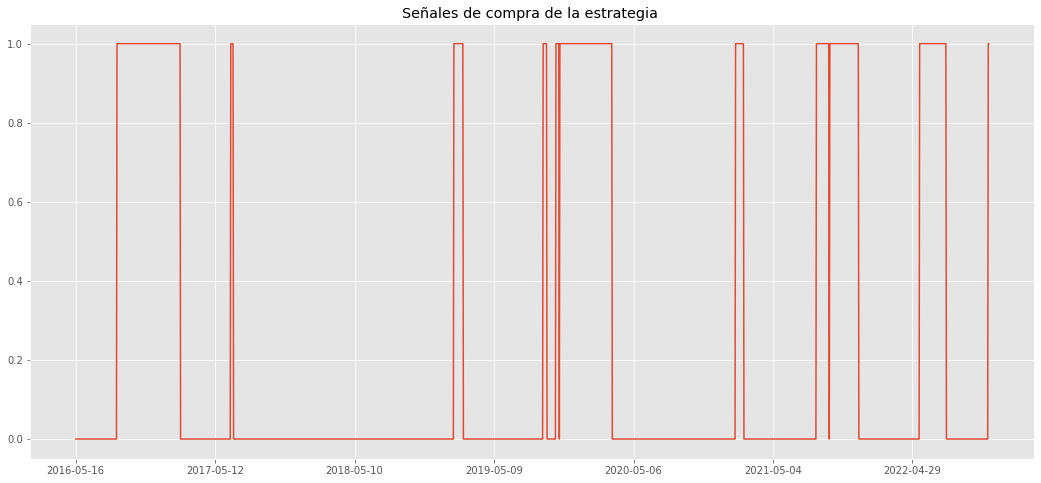

In [17]:
data['Senal'].plot(title = 'Señales de compra de la estrategia ' )
# Ploteando una parte
#data.loc['2010':'2022','Senal'].plot(title = 'Señales Regresión a la media ' +instrumento,xlim=('2010','2022'))

In [18]:
tiempo_final = time() 
 
tiempo_ejecucion = (tiempo_final - tiempo_inicial)/60
 
print ('El tiempo de ejecucion fue:',tiempo_ejecucion,"minutos") #En segundos

El tiempo de ejecucion fue: 24.712288570404052 minutos


In [19]:
data.loc['2011-01-04':'2019-11-04']

,Date,Senal,Price,Objetivo,ExitReason,Beneficio
2016-05-16,2016-05-16,0,92.690002,NaN,NaN,NaN
2016-05-17,2016-05-17,0,90.699997,NaN,NaN,NaN
2016-05-18,2016-05-18,0,89.879997,NaN,NaN,NaN
2016-05-19,2016-05-19,0,90.639999,NaN,NaN,NaN
2016-05-20,2016-05-20,0,90.769997,NaN,NaN,NaN
...,...,...,...,...,...,...
2019-10-29,2019-10-29,1,143.649994,NaN,NaN,NaN
2019-10-30,2019-10-30,1,145.970001,NaN,NaN,NaN
2019-10-31,2019-10-31,1,146.869995,NaN,NaN,NaN
2019-11-01,2019-11-01,1,143.070007,NaN,NaN,NaN


In [20]:
#Guardamos el resultado del analisis en un pickle
#dff.to_pickle("./primerBack_IBE.pkl")

***3.- Ingeniería de datos para calcular la bondad de la estrategia***

In [21]:

data['Dif_Close'] = data.Price.pct_change()
data['Retornos'] = data.Dif_Close * data.Senal.shift(1)   
data['Capital'] = (data.Retornos + 1).cumprod() * 100
    
rg.StrategyClass.dfLog=data  #Ojo a esta liena, no me cuadra.

#quant_j.salvarExcel(StrategyClass.dfLog, "log"+instrumento)   
#data.to_pickle('almacen')    #df = pd.read_pickle(file_name)

>Para calcular los retornos del sistema, calculamos la diferencia relativativa entre el precio de cierre y el del día anterior. Para posteriormente multiplicarlo por la señal que del día anterior que nos indicaba la posición a tomar (si estaba comprado, sumo beneficio).

In [22]:
data.tail()

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2022-11-08,2022-11-08,0,231.070007,NaN,NaN,NaN,0.007719,0.0,126.457933
2022-11-09,2022-11-09,0,230.720001,NaN,NaN,NaN,-0.001515,-0.0,126.457933
2022-11-10,2022-11-10,0,226.300003,NaN,NaN,NaN,-0.019157,-0.0,126.457933
2022-11-11,2022-11-11,1,218.880005,NaN,NaN,12.57291,-0.032788,-0.0,126.457933
2022-11-14,2022-11-14,1,218.119995,NaN,NaN,NaN,-0.003472,-0.003472,126.018838


In [23]:
data[60:]

,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2016-08-10,2016-08-10,0,111.760002,NaN,NaN,NaN,0.013512,0.0,100.0
2016-08-11,2016-08-11,0,112.040001,NaN,NaN,NaN,0.002505,0.0,100.0
2016-08-12,2016-08-12,0,111.470001,NaN,NaN,NaN,-0.005087,-0.0,100.0
2016-08-15,2016-08-15,0,111.82,NaN,NaN,NaN,0.003140,0.0,100.0
2016-08-16,2016-08-16,0,111.5,NaN,NaN,NaN,-0.002862,-0.0,100.0
...,...,...,...,...,...,...,...,...,...
2022-11-08,2022-11-08,0,231.070007,NaN,NaN,NaN,0.007719,0.0,126.457933
2022-11-09,2022-11-09,0,230.720001,NaN,NaN,NaN,-0.001515,-0.0,126.457933
2022-11-10,2022-11-10,0,226.300003,NaN,NaN,NaN,-0.019157,-0.0,126.457933
2022-11-11,2022-11-11,1,218.880005,NaN,NaN,12.57291,-0.032788,-0.0,126.457933


>El capital, por comodidad, lo calcularemos en base 100, es decir como si iniciaramos la inversión con 100 unidades monetarias. Para su calculo arrastramos el producto acumulado de los retornos mas 1, multiplicados como dijimos por 100.

Pero para observar gráficamente la evolución del sistema necesitamos un gráfico con mas información. Para ello definimos una función que nos mostrará un gráfico con la evolución de nuestra estrategia, comparandola con la del activo. En un subgráfico se visualizará el drawdown del sistema, comparado de nuevo con el del activo. Y por útlimo las posiciones que toma el sistema.

In [24]:
def grafico (df):
    estudio = df.copy()
    
    DD_bh, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Dif_Close[60:], info = False) 
    
    DD, maxDD, maxDD_ini, maxDD_fin = analisis.DrawDown(estudio.Retornos.fillna(0), info = False) 

    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(18, 12), gridspec_kw = {'height_ratios':[3, 1, 1]})
    fig.suptitle('Estrategia vs B & H', fontsize=20)

    #Primer plot analiza la evolcuion de una inversion de 100€ en buy&hold y la estrategia)
    ax1.plot(estudio.Capital)
    ax1.plot((estudio.Price) * (100/estudio.Price[1]))
    ax1.set_title('Capital')
    ax1.legend(['Estrategia','Buy & Hold'])

    ax2.plot(DD*100, c='0.5')
    ax2.plot(DD_bh*100, c='y')
    ax2.fill_between(DD.index, 0, DD*100, color='0.7')
    ax2.set_title('Drawdown')
    ax2.legend(['Estrategia','Buy & Hold'])

    ax3.plot(estudio.Senal, c='orange')
    #ax3.fill_between(estudio.index, 0, estudio.Senal*100, color='orange')
    ax3.set_title('Posición')

    plt.show()
    return

In [25]:
print(instrumento)

hsy


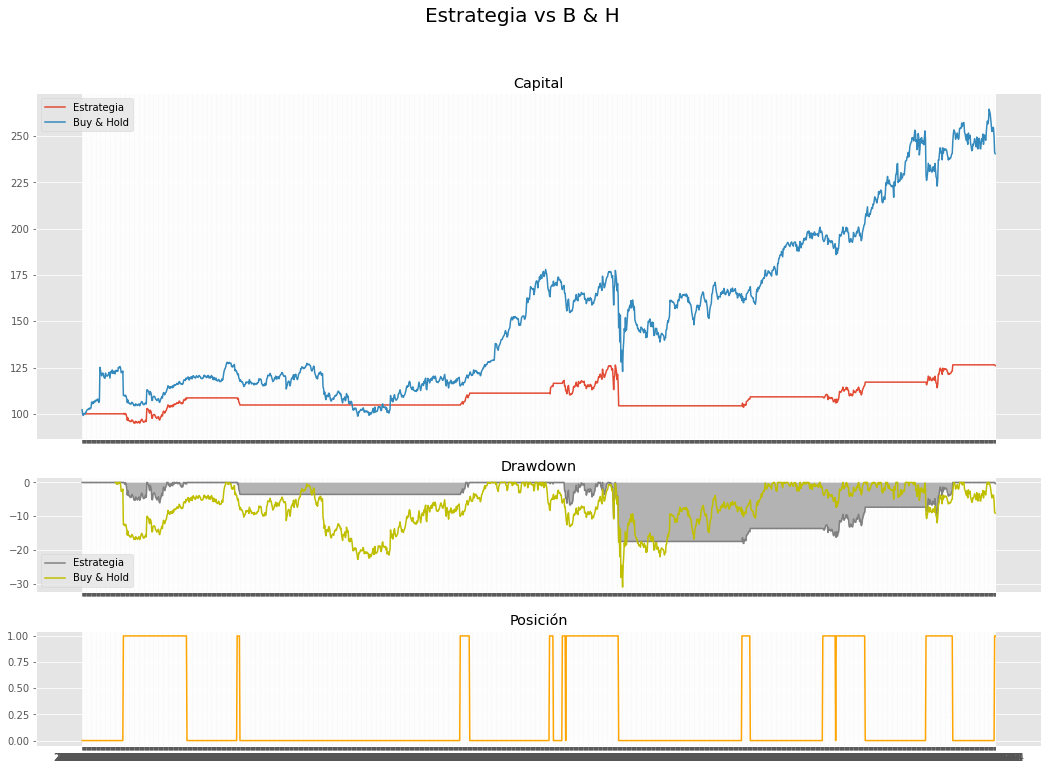

In [26]:
grafico(data)

---

In [27]:
#data[55:70]

---

# ANALISIS DEL SISTEMA

In [28]:
Beneficio_Bruto = data.Capital[-1] - data.Capital[1]
print ('Beneficio Bruto : {:.2f} €  con una inverison de 100€'.format(Beneficio_Bruto))

Beneficio Bruto : 26.02 €  con una inverison de 100€


In [29]:
#Rentabilidad anual compuesta. Calculamos lo que la inversion se ha incrementado cada año con el interes compuesto
CAGR = analisis.CAGR(data.Retornos)
print ('CAGR : {:.2f}%'.format(CAGR * 100))

CAGR : 3.62%


In [30]:
#Ratio calculado restando una rentabilidad segura a nuestra rentabilidad de estrategia y dividido por el riego (=volatilidad)
data.Retornos=data.Retornos.replace(0,np.e)  #Quito los cero (no sepuede hacer logariotmo de cero), pero no se que poner
Sharpe = CAGR / (np.log(data.Retornos + 1).std(skipna=True) * 252 ** 0.5)
print ('Sharpe : {:.3f}'.format(CAGR ))

Sharpe : 0.036


In [31]:
# Actualizo la excel con los economic
regreMedia.analisisEconomics(instrumento)

---


In [32]:
# 

### Cálculo esperanza matemática
 
 (%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)
 
 Nos da idea el benefcio esperado por entrada

In [33]:
print("Numero operaciones con beneficio ->", 
      data[data['ExitReason'] ==1]['ExitReason'].count()) 
print("Numero operaciones con perdidas ->", 
      data[data['ExitReason'] ==-1]['ExitReason'].count()) 
  
data[data['ExitReason']>0]['ExitReason'] 

data[data['Senal']>0][1:10]
data[data['Senal']>0].index[1]

Numero operaciones con beneficio -> 6
Numero operaciones con perdidas -> 4


'2016-08-31'

In [34]:
# ENTRADAS
print (data[(data['Senal']>0) & (data['Beneficio']>0)].index[0])
data[(data['Senal']>0) & (data['Beneficio']>0) ][0:5] 
# SALIDA PERDIDAS
print (data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)].index[0])
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== -1)][0:5]
# SALIDA GANANCIAS
data[(data['Senal'].shift(1) >0) & (data['ExitReason']== 1)][0:5]

2016-08-30
2017-06-29


,Date,Senal,Price,Objetivo,ExitReason,Beneficio,Dif_Close,Retornos,Capital
2017-02-13,2017-02-13,0,108.209999,NaN,1,NaN,0.005482,0.005482,108.590063
2019-02-20,2019-02-20,0,110.68,NaN,1,NaN,0.009025,0.009025,111.166195
2019-09-24,2019-09-24,0,155.660004,NaN,1,NaN,0.015328,0.015328,116.471222
2021-02-18,2021-02-18,0,152.990005,NaN,1,NaN,0.011237,0.011237,109.161096
2021-12-10,2021-12-10,0,186.509995,NaN,1,NaN,0.016403,0.016403,117.109056


In [35]:
serieIndicesENTRADA=data[(data['Senal']>0) & (data['Beneficio']>0)].index

print(serieIndicesENTRADA.size)

serieIndicesENTRADA

serieIndicesEXIT=data[(data['ExitReason']==1) | (data['ExitReason']==-1)].index

print(serieIndicesEXIT.size)

#data['ExitReason'][serieIndicesEXIT[2]]

11
10


In [36]:
serieIndicesENTRADA

Index(['2016-08-30', '2017-06-22', '2019-01-25', '2019-09-13', '2019-10-16',
       '2019-10-25', '2021-01-27', '2021-08-24', '2021-09-28', '2022-05-18',
       '2022-11-11'],
      dtype='object')

In [37]:
#Cálculo Esperanza Matemática
countGanando=0
countPerdiendo=0

bolsaGanando=0
bolsaPerdiendo=0

for i in range(serieIndicesEXIT.size):
    if(data['ExitReason'][serieIndicesEXIT[i]] == -1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print ("-1",ref1, ref2)
        countPerdiendo= 1+countPerdiendo
        bolsaPerdiendo= bolsaPerdiendo + (ref1-ref2)

    
    if(data['ExitReason'][serieIndicesEXIT[i]] == 1):
        ref1  = data['Price'][serieIndicesEXIT[i]]
        ref2 = data['Price'][serieIndicesENTRADA[i]]
        print ("+1",ref1, ref2)
        countGanando= 1+countGanando
        bolsaGanando= bolsaGanando + (ref1-ref2)
    
#(%Aciertos * beneficioMedio )-(%Errores * perdidaMedia)

count=countGanando+countPerdiendo


print ("bolsa ganando   --> ", bolsaGanando, "   Número operaciones ganando   ", countGanando)   
print ("bolsa perdiendo -->", bolsaPerdiendo, "   Número operaciones perdiendo", countPerdiendo) 
print (" Media perdiendo --> ", (bolsaPerdiendo/countPerdiendo),"\n", "Media ganando --> ", (bolsaGanando/countGanando)) 


esperanza = (countGanando/count *(bolsaGanando/countGanando))+(countPerdiendo/count *(bolsaPerdiendo/countPerdiendo))
print("")
print(instrumento)
print("ESPERANZA MATEMATICA ES: ", esperanza)



+1 108.20999908447266 99.6500015258789
-1 106.62000274658203 110.5199966430664
+1 110.68000030517578 104.30000305175781
+1 155.66000366210938 148.57000732421875
-1 146.3699951171875 151.52999877929688
-1 132.8699951171875 143.30999755859375
+1 152.99000549316406 146.19000244140625
-1 170.89999389648438 176.13999938964844
+1 186.50999450683594 168.67999267578125
+1 224.27000427246094 207.69000244140625
bolsa ganando   -->  63.23999786376953    Número operaciones ganando    6
bolsa perdiendo --> -24.740005493164062    Número operaciones perdiendo 4
 Media perdiendo -->  -6.185001373291016 
 Media ganando -->  10.539999643961588

hsy
ESPERANZA MATEMATICA ES:  3.8499992370605463


---